In [1]:
# load packages and functions
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpmisc))
suppressMessages(library(Hmisc))
suppressMessages(library(magrittr))
suppressMessages(library(patchwork))
suppressMessages(library(pROC))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(tidyverse))
suppressMessages(library(viridis))

# cluster annotation
cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::mutate(cluster = as.character(cluster))

In [2]:
# meta data
meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex,age))

meta_add2 = read.table("/projects/jinamo@xsede.org/cytof/data/clinical_data_for_FAN_from_Kat.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(-c(sex))

meta_add3 = read.table("/projects/jinamo@xsede.org/cytof/data/RA_Cleaned_aggregate_vars.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(c(subject_id,HAQ,das28_crp3,bmi,ra_group,pathotype_str,sdai,ccp_type,ccp_range,rf_range,mdtjc28_sum,mdsjc28_sum,criteria_2010_score,heart___1,lung___1,thyroid___1,ibd___1,psoriasis___1,comorb_none___1,alcohol,diabetes,MTX,SSZ,HCQ,LEF,TNFi,ra_group,pathotype_str))

meta_add4 = read.csv("/projects/jinamo@xsede.org/cytof/data/B_All_MD.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = stringr::str_split(file, pattern="_", simplify=TRUE)[,3] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)) %>%
    dplyr::rename(time_point = Visit) %>%
    dplyr::select(c(time_point,subject_id,CDAI)) %>%
    tidyr::pivot_wider(names_from = time_point, values_from = CDAI) %>%
    .[,c("subject_id","V0","V1","V2")] %>%
    magrittr::set_colnames(c("subject_id","CDAI_V0","CDAI_V1","CDAI_V2")) %>%
    dplyr::arrange(subject_id)
meta_total = read.csv("/projects/jinamo@xsede.org/cytof/data/Total_Metadata.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = gsub("-","_",Patient)) %>%
    dplyr::distinct(subject_id,.keep_all = TRUE)


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:
# abundance for each major cell type
cell_prop = readRDS("/projects/jinamo@xsede.org/cytof/data/major_cell_type_abundance.rds") 
cell_prop %<>%
    dplyr::mutate(subject_timepoint = rownames(.),
                  subject_id = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,1],
                  time_point = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,2]) %>%
    dplyr::rename(B = `B cell/plasma cell`,
                  M = `Myeloid`,
                  T = `T cell`) %>%
    tidyr::pivot_longer(-c(subject_timepoint,subject_id,time_point)) %>%
    magrittr::set_colnames(c("subject_timepoint","subject_id","time_point","cell_type","prop")) %>%
    dplyr::mutate(prop = 100*prop)
head(cell_prop,30)
dim(cell_prop)

subject_timepoint,subject_id,time_point,cell_type,prop
<chr>,<chr>,<chr>,<chr>,<dbl>
200_0272__V0,200_0272,V0,B,4.497198
200_0272__V0,200_0272,V0,M,43.488421
200_0272__V0,200_0272,V0,NK,3.053823
200_0272__V0,200_0272,V0,T,48.960558
200_0275__V0,200_0275,V0,B,8.397157
200_0275__V0,200_0275,V0,M,13.159292
200_0275__V0,200_0275,V0,NK,2.090155
200_0275__V0,200_0275,V0,T,76.353396
200_0276__V0,200_0276,V0,B,6.473128


[1] 772   5

In [4]:
## use OR from MASC as coefficients of each cell cluster

# Control vs established RA(V0)
n_min = 10000
frac = 0.90
for (CELL in c("B_cells","NK_cells","T_cells","myeloid")){
  print(CELL)
    # parameter for UMAP
    if (CELL == "B_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.5
    } else if (CELL == "T_cells"){  
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.7
    } else if (CELL == "NK_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    } else if (CELL == "myeloid"){    
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    }
  tmp = readRDS(file = paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/MASC_Control_RAV0_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
  tmp %<>% 
    magrittr::set_colnames(c("cluster","size","model_pval","OR","CIlower","CIupper")) %>%
    dplyr::mutate(cluster = paste0(CELL,"_",cluster)) 
  if (CELL == "B_cells"){
    masc = tmp
  } else {
    masc = rbind(tmp,masc)
  }
}
rownames(masc) = masc$cluster
masc %<>% 
    dplyr::mutate(NegLog_pval = -log(model_pval),
                  LogOR = log(OR),
                  scaled_OR = LogOR*NegLog_pval,
                  # scaled_OR = log(OR),
                  FDR = qvalue::qvalue(model_pval)$qvalues,
                  # FDR = model_pval*length(unique(cluster)),
                  # scaled_OR = ifelse(model_pval<0.05, log(OR), 0),
                  # scaled_OR = ifelse(FDR<0.1, log(OR), 0)
                  )
                  
masc %>% dplyr::arrange(scaled_OR) %>% print()
masc %>% dplyr::arrange(FDR)

[1] "B_cells"
[1] "NK_cells"
[1] "T_cells"
[1] "myeloid"
                              cluster   size   model_pval        OR    CIlower
T_cells_cluster12   T_cells_cluster12  38123 4.860500e-09 0.4400042 0.31814435
NK_cells_cluster14 NK_cells_cluster14   4794 9.360934e-05 0.3610717 0.19868495
NK_cells_cluster7   NK_cells_cluster7  25845 3.299849e-04 0.3214978 0.19708449
NK_cells_cluster8   NK_cells_cluster8  20621 7.487304e-04 0.3454027 0.30025489
NK_cells_cluster9   NK_cells_cluster9  16297 3.875293e-03 0.3056416 0.24507751
B_cells_cluster19   B_cells_cluster19     20 3.607599e-02 0.1571732 0.03312734
myeloid_cluster5     myeloid_cluster5  36454 1.426468e-03 0.5953215 0.42728241
myeloid_cluster15   myeloid_cluster15   1662 4.049557e-03 0.6685570 0.51961905
B_cells_cluster18   B_cells_cluster18     26 1.053468e-01 0.4626426 0.18706928
T_cells_cluster25   T_cells_cluster25     15 2.586278e-01 0.3749268 0.07016538
T_cells_cluster8     T_cells_cluster8  54466 7.840256e-03 0.7841274 0.6567

,cluster,size,model_pval,OR,CIlower,CIupper,NegLog_pval,LogOR,scaled_OR,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T_cells_cluster12,T_cells_cluster12,38123,4.860500e-09,0.4400042,0.31814435,0.6085403,19.142125,-0.8209711,-15.7151308,3.670482e-07
NK_cells_cluster14,NK_cells_cluster14,4794,9.360934e-05,0.3610717,0.19868495,0.6561784,9.276380,-1.0186788,-9.4496517,3.534528e-03
NK_cells_cluster4,NK_cells_cluster4,71778,3.548937e-04,1.4118558,1.27504673,1.5633441,7.943692,0.3449050,2.7398192,6.700087e-03
NK_cells_cluster7,NK_cells_cluster7,25845,3.299849e-04,0.3214978,0.19708449,0.5244494,8.016464,-1.1347646,-9.0967990,6.700087e-03
NK_cells_cluster8,NK_cells_cluster8,20621,7.487304e-04,0.3454027,0.30025489,0.3973392,7.197132,-1.0630442,-7.6508689,1.130831e-02
myeloid_cluster5,myeloid_cluster5,36454,1.426468e-03,0.5953215,0.42728241,0.8294459,6.552553,-0.5186537,-3.3985064,1.795366e-02
myeloid_cluster15,myeloid_cluster15,1662,4.049557e-03,0.6685570,0.51961905,0.8601848,5.509148,-0.4026337,-2.2181684,3.058086e-02
T_cells_cluster14,T_cells_cluster14,26767,3.391974e-03,1.1986771,1.08737648,1.3213702,5.686343,0.1812185,1.0304708,3.058086e-02
T_cells_cluster19,T_cells_cluster19,9924,2.982195e-03,1.4773487,1.23321999,1.7698053,5.815096,0.3902491,2.2693358,3.058086e-02


In [5]:

## calculate proportion of each cluster in each major cell population

# set parameters
n_min = 10000
frac = 0.90

for (CELL in c("B_cells","NK_cells","T_cells","myeloid")){
  
  print(CELL)
  # parameter for UMAP
    if (CELL == "B_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.5
    } else if (CELL == "T_cells"){  
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.7
    } else if (CELL == "NK_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    } else if (CELL == "myeloid"){    
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    }
    
  umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
  # remove clusters less than cut off
  min_cell_cluster = 30
  clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
  clu_logi = umap_res$res_cell %in% clu
  umap_res = umap_res[clu_logi,]
  
  if (CELL %in% c("B_cells","T_cells","myeloid")){
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  } else if (CELL %in% c("NK_cells")){  
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  }
  
  
  print(head(umap_res))
  print(dim(umap_res))
  print(head(batch_fl))
  print(dim(batch_fl))
  print(colnames(batch_fl))
  
  tmp = cbind(cluster = umap_res$res_cell,batch_fl) %>%
    dplyr::group_by(subject_id,time_point,cluster) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(subject_id,time_point) %>%
    dplyr::mutate(proportion = 100*count/sum(count),
                  subject_timepoint = paste(subject_id,time_point,sep="__")) %>%
    merge(.,
          batch_fl[,c("subject_id","disease")] %>%
            unique(),
          by = "subject_id") %>%
    dplyr::arrange(subject_id,cluster)
  for (ind in unique(tmp$subject_timepoint)){
    # print(paste0(grep(ind,unique(tmp$subject_id)),"/",length(unique(tmp$subject_id))))
    tmp_ind = tmp[tmp$subject_timepoint == ind,]
    for (clu in unique(umap_res$res_cell)[order(as.integer(unique(umap_res$res_cell)))]){
      # print(clu)
      if (nrow(tmp_ind[tmp_ind$cluster == clu,])==0){
        tmp = tmp %>% dplyr::add_row(subject_id = unique(tmp_ind$subject_id), subject_timepoint = ind, time_point = unique(tmp_ind$time_point), cluster = clu, count = 0, proportion = 0, disease = unique(tmp_ind$disease))
      }
    }
  }
  tmp = tmp %>% dplyr::arrange(subject_id,time_point,cluster) %>% dplyr::mutate(cluster = paste0(CELL,"_cluster",cluster), cell = ifelse(CELL %in% c("B_cells","NK_cells","T_cells"), gsub("_cells","",CELL),"M"))
  
  if (CELL == "B_cells"){
    df = tmp
  } else {
    df = rbind(tmp,df)
  }
  
}



[1] "B_cells"
       UMAP1      UMAP2 disease batch res_cell
1  0.7365184 -2.7977917 Control    15        0
2  2.4667720 -0.2356597 Control    15       12
3  0.1987944 -2.7129869 Control    15        0
4  0.1210516 -3.5780368 Control    15        0
5 -0.9618028  6.6663339 Control    15        7
6  3.5014135  0.1042377 Control    15       12
[1] 1918239       5
                  OmiqFileIndex disease Age Baseline batch CDAI CS CS_V0
1 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
2 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
3 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
4 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
5 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
6 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
  Cellcept DMARD Disease HCQ HCQ_V0 ISN.Class Longitudinal  Patient    Sex
1        0    NA Control   0     NA      <NA>      

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "NK_cells"
       UMAP1     UMAP2 disease batch res_cell
1 -1.0852492 -5.609421 Control    15        1
2 -0.7627611 -4.311282 Control    15        1
3 -3.9263222  4.287653 Control    15        2
4 -3.3761160  3.396924 Control    15        0
5 12.2806943 -2.012380 Control    15        8
6  0.3788578 -8.128912 Control    15        6
[1] 2008702       5
            OmiqFileIndex disease                    file Age Baseline    Batch
1 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
2 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
3 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
4 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
5 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
6 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
  CDAI CS CS_V0 Cellcept DMARD Disease HCQ HCQ_V0 ISN.Class Longitudinal
1   NA  0 

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "T_cells"
      UMAP1     UMAP2 disease batch res_cell
1 -9.449675 -2.127851 Control    15        8
2 -5.845147  1.816677 Control    15       12
3  6.496284  2.399950 Control    15        7
4  3.813404  3.555250 Control    15        5
5  2.793026  4.641660 Control    15        1
6  7.370950 -4.017954 Control    15        0
[1] 2196401       5
                   OmiqFileIndex disease Unfiltered.count batch Disease
1 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
2 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
3 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
4 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
5 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
6 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
  condition time_point subject_id
1   Control         V0   200_0272
2   Control         V0   200_0272
3   Control         V0   200_0272
4   Control

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "myeloid"
       UMAP1       UMAP2 disease batch res_cell
1  2.0532372   0.7853604 Control    15        0
2 -0.3599584  -1.2624608 Control    15        1
3 -4.5085528 -14.3289069 Control    15        5
4 -0.6125778   3.6431667 Control    15        0
5  1.3293630   2.2799052 Control    15        0
6 -0.2884055  -1.4845810 Control    15        1
[1] 1885837       5
                    OmiqFileIndex disease  sampleID patientID batch condition
1 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
2 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
3 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
4 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
5 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
6 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
  time_point subject_id
1         V0   200_0272
2         V0   200_0272
3         V0

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


In [6]:
# To account for major cell population, multiply proportion of each cluster by proportion of major cell population

df %<>%
    dplyr::select(-c(subject_id,time_point)) %>%
    dplyr::left_join(.,cell_prop,by="subject_timepoint") %>%
    dplyr::filter(cell_type == cell) %>%
    dplyr::mutate(proportion = proportion*prop/100) %>%
    dplyr::select(-c(cell,prop))

In [7]:
# transform to wide data frame
df_wide = df %>%
    dplyr::select(-c(count,cell_type)) %>%
    tidyr::pivot_wider(names_from = cluster, values_from = proportion) %>%
    dplyr::left_join(.,meta,by="subject_id") %>%
    dplyr::left_join(.,meta_add,by="subject_id") %>%
    dplyr::left_join(.,meta_add2,by="subject_id") %>%
    dplyr::left_join(.,meta_add3,by="subject_id") %>%
    dplyr::left_join(.,meta_add4,by="subject_id") %>%
    dplyr::mutate_at(vars(matches("^(B_cells|NK_cells|T_cells|myeloid)_cluster.*")), ~replace_na(.,0)) %>%
    dplyr::arrange(subject_timepoint)
df_wide$AtRisk = dplyr::case_when(
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  df_wide$diagnosis == "Control" ~ "Control",
  df_wide$diagnosis == "RA" ~ "RA")
df_wide$AtRisk = factor(df_wide$AtRisk,levels=c("Control","FDR(-)/ACPA(-)","FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA"))
df_wide$diagnosis = ifelse(df_wide$AtRisk == "FDR(-)/ACPA(-)", "Control", as.character(df_wide$diagnosis))
df_wide$diagnosis = factor(df_wide$diagnosis, levels=c("Control","AtRiskRA","RA"))
df_wide$diagnosis_time = paste(df_wide$diagnosis,df_wide$time_point,sep="_") %>% factor(., levels=c("Control_V0","AtRiskRA_V0","RA_V0","RA_V1","RA_V2"))

head(df_wide)
dim(df_wide)



subject_timepoint,disease,subject_id,time_point,myeloid_cluster0,myeloid_cluster1,myeloid_cluster10,myeloid_cluster11,myeloid_cluster12,myeloid_cluster13,...,MTX,SSZ,HCQ,LEF,TNFi,CDAI_V0,CDAI_V1,CDAI_V2,AtRisk,diagnosis_time
<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
200_0272__V0,Control,200_0272,V0,17.723304,12.773827,0.5045161,0.1348276,1.22649613,0.15657397,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0
200_0275__V0,Control,200_0275,V0,4.892287,2.854821,0.3053566,0.1224059,0.00000000,0.01447812,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0
200_0276__V0,Control,200_0276,V0,2.710466,3.039717,0.6054466,0.3105255,0.00000000,0.01404386,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0
200_0281__V0,Control,200_0281,V0,9.302227,7.228451,0.4613905,0.1959669,0.50604115,0.04465069,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0
200_0282__V0,Control,200_0282,V0,2.766971,1.917005,0.4623364,0.2734551,0.00000000,0.05215380,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0
200_0283__V0,Control,200_0283,V0,9.751721,6.732775,1.4160433,0.1985380,0.01167871,0.05547386,...,NA,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0


[1] 192 166

In [8]:
## scale by log function
prop_mat = df_wide %>% 
    dplyr::mutate(across(contains("_cluster"), ~ .x + 1)) %>%
    .[,grepl("cluster",colnames(df_wide))] %>%
    log() %>%
    .[,unique(masc$cluster)]
head(prop_mat)
dim(prop_mat)

myeloid_cluster0,myeloid_cluster1,myeloid_cluster10,myeloid_cluster11,myeloid_cluster12,myeloid_cluster13,myeloid_cluster14,myeloid_cluster15,myeloid_cluster2,myeloid_cluster3,...,B_cells_cluster18,B_cells_cluster19,B_cells_cluster2,B_cells_cluster3,B_cells_cluster4,B_cells_cluster5,B_cells_cluster6,B_cells_cluster7,B_cells_cluster8,B_cells_cluster9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.929769,2.622770,0.4084713,0.1264807,0.80042911,0.14546216,0,0.06727393,1.1592954,0.13791277,...,0.0000000000,0.0000000000,0.5143946,0.5871118,0.3219761,0.2631345,0.1915960,0.10532872,0.08915382,0.05014541
1.773644,1.349325,0.2664763,0.1154745,0.00000000,0.01437431,0,0.01955052,0.8365093,1.02179457,...,0.0000000000,0.0000000000,0.8764506,0.5240320,0.4905555,0.3028256,0.6885178,0.18874098,0.28265734,0.07079505
1.311157,1.396175,0.4734020,0.2704282,0.00000000,0.01394616,0,0.01394616,0.6387575,1.73580376,...,0.0000000000,0.0000000000,0.6162540,0.6911744,0.4611069,0.3925619,0.2403171,0.22804638,0.11962243,0.09125977
2.332360,2.107598,0.3793884,0.1789550,0.40948445,0.04368256,0,0.02450327,1.2578366,0.04130517,...,0.0000000000,0.0000000000,0.5069107,0.8168560,0.2653730,0.8035097,0.4579976,0.50226534,0.08901652,0.12156346
1.326271,1.070557,0.3800354,0.2417337,0.00000000,0.05083930,0,0.02092301,0.8782744,0.73966326,...,0.0000000000,0.0000000000,0.3969148,0.6870506,0.1581427,0.4483694,0.1443348,0.34709278,0.07559696,0.20065084
2.375066,2.045468,0.8821312,0.1811025,0.01161104,0.05398982,0,0.01736639,1.7093736,0.82621627,...,0.0007508205,0.0007508205,0.5734548,0.6839505,0.3452587,0.2345883,0.2440481,0.07102497,0.16446506,0.04551657


[1] 192  78

In [9]:
# extract coefficients of significant cluster
merge(masc,
      cluster_df %>%
        dplyr::mutate(cluster=paste0(ifelse(cell=="M","myeloid",paste0(cell,"_cells")),"_cluster",cluster)),
      by="cluster") %>% 
  dplyr::filter(FDR<0.05)
vec = masc %>% 
    dplyr::mutate(scaled_OR_FDR = ifelse(FDR<0.05, scaled_OR, 0)) %>%
    dplyr::select(c(scaled_OR_FDR)) %>%
    t() %>%
    .[,unique(masc$cluster)]
vec
all(names(vec) == colnames(prop_mat))


cluster,size,model_pval,OR,CIlower,CIupper,NegLog_pval,LogOR,scaled_OR,FDR,cell,clu_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NK_cells_cluster14,4794,9.360934e-05,0.3610717,0.1986849,0.6561784,9.276380,-1.0186788,-9.449652,3.534528e-03,NK,CD56-/dimCD16-CD2-CD57-GZMB+HLADR+CD4+
NK_cells_cluster4,71778,3.548937e-04,1.4118558,1.2750467,1.5633441,7.943692,0.3449050,2.739819,6.700087e-03,NK,CD56dimCD16+CD2+CD57dimKi67+
NK_cells_cluster7,25845,3.299849e-04,0.3214978,0.1970845,0.5244494,8.016464,-1.1347646,-9.096799,6.700087e-03,NK,CD56-/dimCD16-CD2dimCD57-HLADR+Ki67+CD39+PSGL1+
NK_cells_cluster8,20621,7.487304e-04,0.3454027,0.3002549,0.3973392,7.197132,-1.0630442,-7.650869,1.130831e-02,NK,CD56-/dimCD16-CD2-CD57-CD11b+
NK_cells_cluster9,16297,3.875293e-03,0.3056416,0.2450775,0.3811725,5.553134,-1.1853420,-6.582363,3.058086e-02,NK,CD56-/dimCD16dimCD2-CD57-HLADR+CD39+DAP12+
T_cells_cluster12,38123,4.860500e-09,0.4400042,0.3181443,0.6085403,19.142125,-0.8209711,-15.715131,3.670482e-07,T,Tbet+GZMK+CCR2+CD161+ DNT
T_cells_cluster14,26767,3.391974e-03,1.1986771,1.0873765,1.3213702,5.686343,0.1812185,1.030471,3.058086e-02,T,Tph (ICOS+ EMCD4)
T_cells_cluster19,9924,2.982195e-03,1.4773487,1.2332200,1.7698053,5.815096,0.3902491,2.269336,3.058086e-02,T,GZMB+HLA-DR+Ki67+ EMCD8
myeloid_cluster15,1662,4.049557e-03,0.6685570,0.5196191,0.8601848,5.509148,-0.4026337,-2.218168,3.058086e-02,M,CD141+CLEC9A+ cDC (cDC1)


myeloid_cluster0   myeloid_cluster1  myeloid_cluster10  myeloid_cluster11 
          0.000000           0.000000           0.000000           0.000000 
 myeloid_cluster12  myeloid_cluster13  myeloid_cluster14  myeloid_cluster15 
          0.000000           0.000000           0.000000          -2.218168 
  myeloid_cluster2   myeloid_cluster3   myeloid_cluster4   myeloid_cluster5 
          0.000000           0.000000           0.000000          -3.398506 
  myeloid_cluster6   myeloid_cluster7   myeloid_cluster8   myeloid_cluster9 
          0.000000           0.000000           0.000000           0.000000 
  T_cells_cluster0   T_cells_cluster1  T_cells_cluster10  T_cells_cluster11 
          0.000000           0.000000           0.000000           0.000000 
 T_cells_cluster12  T_cells_cluster13  T_cells_cluster14  T_cells_cluster15 
        -15.715131           0.000000           1.030471           0.000000 
 T_cells_cluster16  T_cells_cluster17  T_cells_cluster18  T_cells_cluster19 
          0.000000           0.000000           0.000000           2.269336 
  T_cells_cluster2  T_cells_cluster20  T_cells_cluster21  T_cells_cluster22 
          0.000000           0.000000           0.000000           0.000000 
 T_cells_cluster23  T_cells_cluster24  T_cells_cluster25   T_cells_cluster3 
          0.000000           0.000000           0.000000           0.000000 
  T_cells_cluster4   T_cells_cluster5   T_cells_cluster6   T_cells_cluster7 
          0.000000           0.000000           0.000000           0.000000 
  T_cells_cluster8   T_cells_cluster9  NK_cells_cluster0  NK_cells_cluster1 
          0.000000           0.000000           0.000000           0.000000 
NK_cells_cluster10 NK_cells_cluster11 NK_cells_cluster12 NK_cells_cluster13 
          0.000000           0.000000           0.000000           0.000000 
NK_cells_cluster14 NK_cells_cluster15 NK_cells_cluster16  NK_cells_cluster2 
         -9.449652           0.000000           0.000000           0.000000 
 NK_cells_cluster3  NK_cells_cluster4  NK_cells_cluster5  NK_cells_cluster6 
          0.000000           2.739819           0.000000           0.000000 
 NK_cells_cluster7  NK_cells_cluster8  NK_cells_cluster9   B_cells_cluster0 
         -9.096799          -7.650869          -6.582363           0.000000 
  B_cells_cluster1  B_cells_cluster10  B_cells_cluster11  B_cells_cluster12 
          0.000000           0.000000           0.000000           0.000000 
 B_cells_cluster13  B_cells_cluster14  B_cells_cluster15  B_cells_cluster17 
          0.000000           0.000000           0.000000           0.000000 
 B_cells_cluster18  B_cells_cluster19   B_cells_cluster2   B_cells_cluster3 
          0.000000           0.000000           0.000000           0.000000 
  B_cells_cluster4   B_cells_cluster5   B_cells_cluster6   B_cells_cluster7 
          0.000000           0.000000           0.000000           0.000000 
  B_cells_cluster8   B_cells_cluster9 
          0.000000           0.000000

[1] TRUE

In [10]:
# multiply coefficients and sum of them to get RA score

range01 <- function(x){(x-min(x))/(max(x)-min(x))}
# df_wide$AtRiskScore = range01(rowSums(t(t(prop_mat)*vec)))
df_wide$AtRiskScore = range01(rowSums(t(t(prop_mat)*vec)))
head(df_wide)


subject_timepoint,disease,subject_id,time_point,myeloid_cluster0,myeloid_cluster1,myeloid_cluster10,myeloid_cluster11,myeloid_cluster12,myeloid_cluster13,...,SSZ,HCQ,LEF,TNFi,CDAI_V0,CDAI_V1,CDAI_V2,AtRisk,diagnosis_time,AtRiskScore
<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
200_0272__V0,Control,200_0272,V0,17.723304,12.773827,0.5045161,0.1348276,1.22649613,0.15657397,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.18048728
200_0275__V0,Control,200_0275,V0,4.892287,2.854821,0.3053566,0.1224059,0.00000000,0.01447812,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.46010707
200_0276__V0,Control,200_0276,V0,2.710466,3.039717,0.6054466,0.3105255,0.00000000,0.01404386,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.04451693
200_0281__V0,Control,200_0281,V0,9.302227,7.228451,0.4613905,0.1959669,0.50604115,0.04465069,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.19334343
200_0282__V0,Control,200_0282,V0,2.766971,1.917005,0.4623364,0.2734551,0.00000000,0.05215380,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.58776365
200_0283__V0,Control,200_0283,V0,9.751721,6.732775,1.4160433,0.1985380,0.01167871,0.05547386,...,NA,NA,NA,NA,NA,NA,NA,Control,Control_V0,0.68711604


In [11]:
med_df <- df_wide %>%
  dplyr::group_by(diagnosis) %>%
  dplyr::summarize(median=median(AtRiskScore))
med_df

diagnosis,median
<fct>,<dbl>
Control,0.4632524
AtRiskRA,0.6063391
RA,0.7703329


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


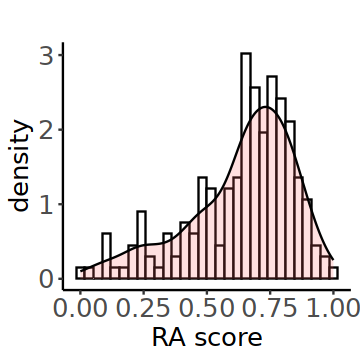

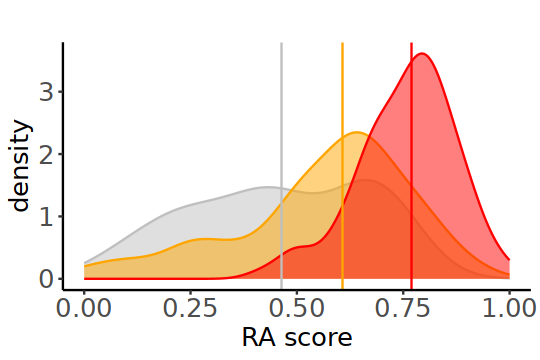

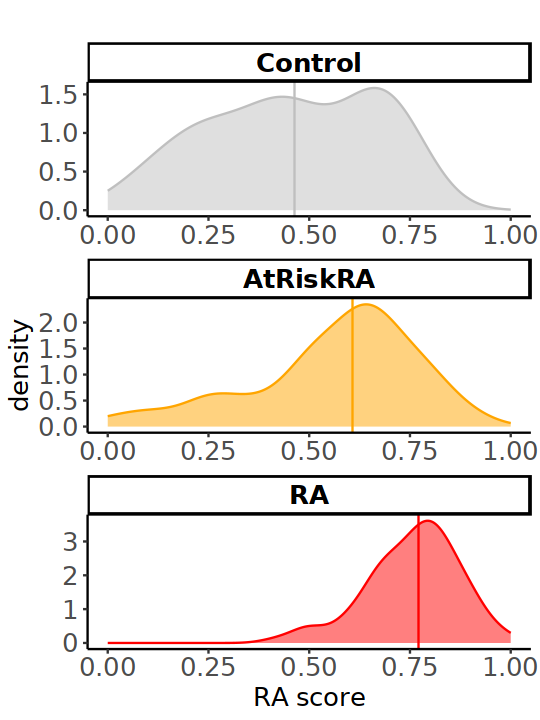

In [12]:
options(repr.plot.height = 3, repr.plot.width = 3)
ggplot(df_wide, aes(x=AtRiskScore)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white")+
 geom_density(alpha=.2, fill="#FF6666") +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "",
         x = "RA score",
         y = "density") 

options(repr.plot.height = 3, repr.plot.width = 4.5)
ggplot(df_wide, aes(x=AtRiskScore)) + 
 # geom_histogram(aes(y=..density.., colour=diagnosis, fill=diagnosis), alpha = 0.5)+
 geom_density(aes(y=..density.., colour=diagnosis, fill=diagnosis), alpha = 0.5) +
 geom_vline(data = med_df, aes(xintercept = median, color = diagnosis), size=0.5)+
    xlim(0,1) +
    scale_color_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    scale_fill_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "",
         x = "RA score",
         y = "density") 

options(repr.plot.height = 6, repr.plot.width = 4.5)
ggplot(df_wide, aes(x=AtRiskScore)) + 
 # geom_histogram(aes(y=..density.., colour=AtRisk, fill=AtRisk), alpha = 0.5)+
 geom_density(aes(y=..density.., colour=diagnosis, fill=diagnosis), alpha = 0.5) +
    geom_vline(data = med_df, aes(xintercept = median, color = diagnosis), size=0.5)+
    facet_wrap( ~ diagnosis, ncol = 1, scales = "free") +
    xlim(0,1) +
    scale_color_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    scale_fill_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "",
         x = "RA score",
         y = "density") 

# A tibble: 3 × 2
  diagnosis   med
  <fct>     <dbl>
1 Control   0.463
2 AtRiskRA  0.606
3 RA        0.770


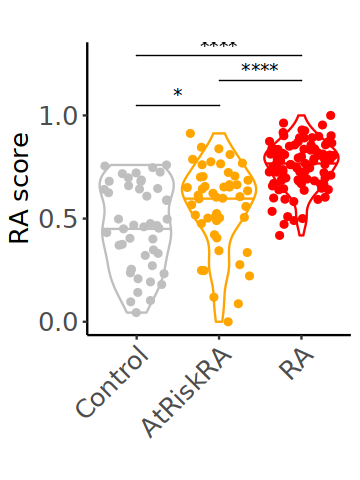

In [13]:
options(repr.plot.height = 4, repr.plot.width = 3)
df_wide %>%
  dplyr::group_by(diagnosis) %>%
  dplyr::summarize(med = quantile(AtRiskScore, probs = c(0.5))) %>% print()
plot(
    ggplot(df_wide, aes(x = diagnosis, y=AtRiskScore, fill = diagnosis, color = diagnosis)) + 
    geom_violin(aes(color = diagnosis), fill = "white", scale = "width", draw_quantiles = c(0.5)) +
    geom_jitter(aes(fill = diagnosis, color = diagnosis)) +
    ggpubr::stat_compare_means(
      comparisons = list(c("Control", "AtRiskRA"), c("AtRiskRA", "RA"),  c("Control", "RA")), 
      label = "p.signif",
      tip.length = 0
    ) +
    scale_color_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    scale_fill_manual(values=c("grey75","orange","red"), labels=c("Control","AtRiskRA","RA")) +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 45, hjust=1),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "",
         x = "",
         y = "RA score") 
)


Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


,PANEL,group,group.1,AUC
,<fct>,<int>,<fct>,<dbl>
1,1,1,FDR(+)/ACPA(-),0.6552795
2,1,2,FDR(-)/ACPA(+),0.4945652
3,1,3,FDR(+)/ACPA(+),0.6967391
4,1,4,RA,0.9040789


Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


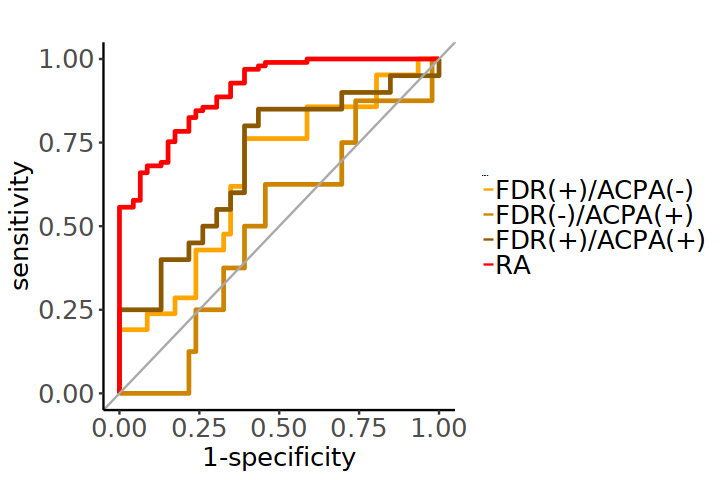

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


,PANEL,group,group.1,AUC
,<fct>,<int>,<fct>,<dbl>
1,1,1,FDR(+)/ACPA(-),0.6552795
2,1,2,ACPA(+),0.6389752
3,1,3,RA,0.9040789


Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


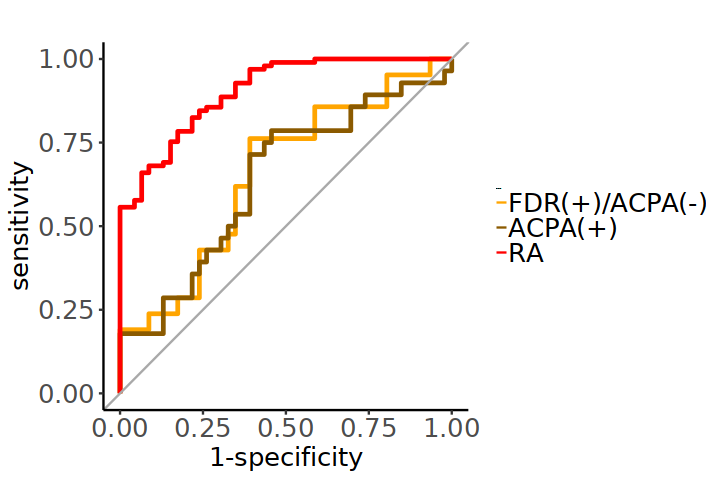

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


,PANEL,group,group.1,AUC
,<fct>,<int>,<fct>,<dbl>
1,1,1,at-risk,0.6459627
2,1,2,RA,0.9040789


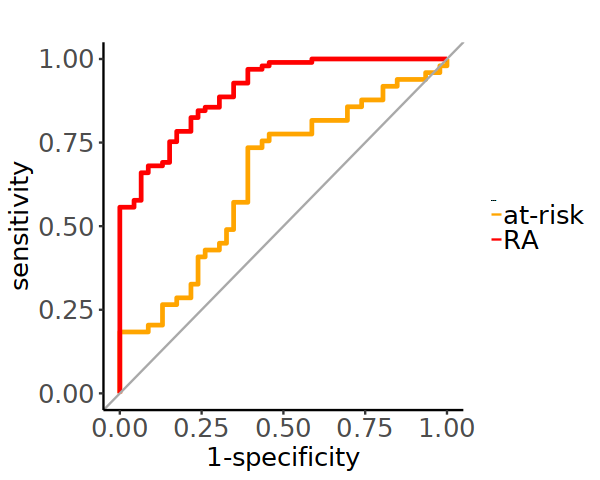

In [14]:
options(repr.plot.height = 4, repr.plot.width = 6)

rocdata = rbind(
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("RA"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "RA"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(+)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "FDR(+)/ACPA(+)"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(-)/ACPA(+)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "FDR(-)/ACPA(+)"),
  # df_wide %>%
  #   dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(+)","FDR(-)/ACPA(+)"), 1,
  #                                        ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
  #                 group = "ACPA(+)"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(-)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "FDR(+)/ACPA(-)")
) %>%
  dplyr::mutate(group = factor(group,levels = c("FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA"))) %>%
  dplyr::select(condition_val,AtRiskScore,group)
ggroc2 <- ggplot(rocdata, aes(m = AtRiskScore, d = condition_val, color = group)) + 
  plotROC::geom_roc(n.cuts = 0, labels = FALSE) +
　　　　geom_abline(color = "dark grey", size = 0.5) + # AUROC=0.5となるラインを描画
  scale_fill_manual(values=c("orange","orange3","orange4","red"), labels=c("FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA")) +
  scale_color_manual(values=c("orange","orange3","orange4","red"), labels=c("FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA")) + 
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       x = "1-specificity",
       y = "sensitivity") 
ggroc2
plotROC::calc_auc(ggroc2)

rocdata = rbind(
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("RA"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "RA"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(+)","FDR(-)/ACPA(+)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "ACPA(+)"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(-)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "FDR(+)/ACPA(-)")
) %>%
  dplyr::mutate(group = factor(group,levels = c("FDR(+)/ACPA(-)","ACPA(+)","RA"))) %>%
  dplyr::select(condition_val,AtRiskScore,group)
ggroc2 <- ggplot(rocdata, aes(m = AtRiskScore, d = condition_val, color = group)) + 
  plotROC::geom_roc(n.cuts = 0, labels = FALSE) +
　　　　geom_abline(color = "dark grey", size = 0.5) + # AUROC=0.5となるラインを描画
  scale_fill_manual(values=c("orange","orange4","red"), labels=c("FDR(+)/ACPA(-)","ACPA(+)","RA")) +
  scale_color_manual(values=c("orange","orange4","red"), labels=c("FDR(+)/ACPA(-)","ACPA(+)","RA")) + 
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       x = "1-specificity",
       y = "sensitivity") 
ggroc2
plotROC::calc_auc(ggroc2)

options(repr.plot.height = 4, repr.plot.width = 5)
rocdata = rbind(
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("RA"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "RA"),
  df_wide %>%
    dplyr::mutate(condition_val = ifelse(AtRisk %in% c("FDR(+)/ACPA(+)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)"), 1,
                                         ifelse(AtRisk %in% c("Control","FDR(-)/ACPA(-)"), 0, NA)),
                  group = "at-risk")
) %>%
  dplyr::mutate(group = factor(group,levels = c("at-risk","RA"))) %>%
  dplyr::select(condition_val,AtRiskScore,group)
ggroc2 <- ggplot(rocdata, aes(m = AtRiskScore, d = condition_val, color = group)) + 
  plotROC::geom_roc(n.cuts = 0, labels = FALSE) +
　　　　geom_abline(color = "dark grey", size = 0.5) + # AUROC=0.5となるラインを描画
  scale_fill_manual(values=c("orange","red"), labels=c("at-risk","RA")) +
  scale_color_manual(values=c("orange","red"), labels=c("at-risk","RA")) + 
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       x = "1-specificity",
       y = "sensitivity") 
ggroc2
plotROC::calc_auc(ggroc2)
